### About

Demonstration of Mr.ASH penalized regression on trendfiltering problems and optimization of $w_k$

In [1]:
#collapse-hide

import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.utils                          import R_genlasso
from mrashpen.models                         import mixture_gaussian as mix_gauss

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

In [2]:
def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_trendfilter_mrashpen(X, y, beta, ytest, bhat,
                              intercept = 0, title = None):
    n = y.shape[0]
    p = X.shape[1]

    ypred = np.dot(X, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white')
    ax1.plot(np.arange(n), ypred)
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white')
    ax2.scatter(np.arange(p), bhat, s = 40, color = 'firebrick')
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()

def plot_convergence(objs, methods, nwarm, eps = 1e-8):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, nwarm):
        m_obj = np.array(obj)[iteq:] - objmin
        m_obj = m_obj[m_obj > 0]
        ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
                 marker = 'o', markersize = 1)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def linreg_summary_df(sigma2, objs, methods):
    data     = [[strue * strue,  '-', '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        if isinstance(obj.elbo_path, list) or isinstance(obj.elbo_path, np.ndarray):
            elbo = obj.elbo_path[-1]
        else:
            elbo = obj.elbo_path
        data.append([obj.residual_var, elbo, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'ELBO', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

In [3]:
n = 200
p = 200
p_causal = 2
snr = 200
k = 10

X, y, Xtest, ytest, btrue, strue = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                    k = 1, signal = 'gamma', seed = 100)
wk, sk = initialize_ash_prior(k, scale = 4)

In [4]:
genlasso_a0, genlasso_b, genlasso_fit = R_genlasso.fit(X, y, order = 1)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [5]:
genlasso_b[genlasso_b > 1e-2]

array([0.01010193, 0.01032637, 0.01055081, 0.01583436, 0.02462336,
       0.03341236, 0.04220136, 0.05099036, 0.05977935, 0.06856835,
       0.07735735, 0.08614635, 0.09493534, 0.10372434, 0.11251334,
       0.12130234, 0.13009133, 0.13028384, 0.12660974, 0.12293564,
       0.11926155, 0.11558745, 0.11191335, 0.10823926, 0.10456516,
       0.10089106, 0.09721696, 0.09354287, 0.08986877, 0.08619467,
       0.08252057, 0.07884648, 0.07517238, 0.07149828, 0.06782418,
       0.06415009, 0.06047599, 0.05680189, 0.05312779, 0.0494537 ,
       0.0457796 , 0.0421055 , 0.0384314 , 0.03475731, 0.03108321,
       0.02740911, 0.02373501, 0.02006092, 0.01638682, 0.01316067])

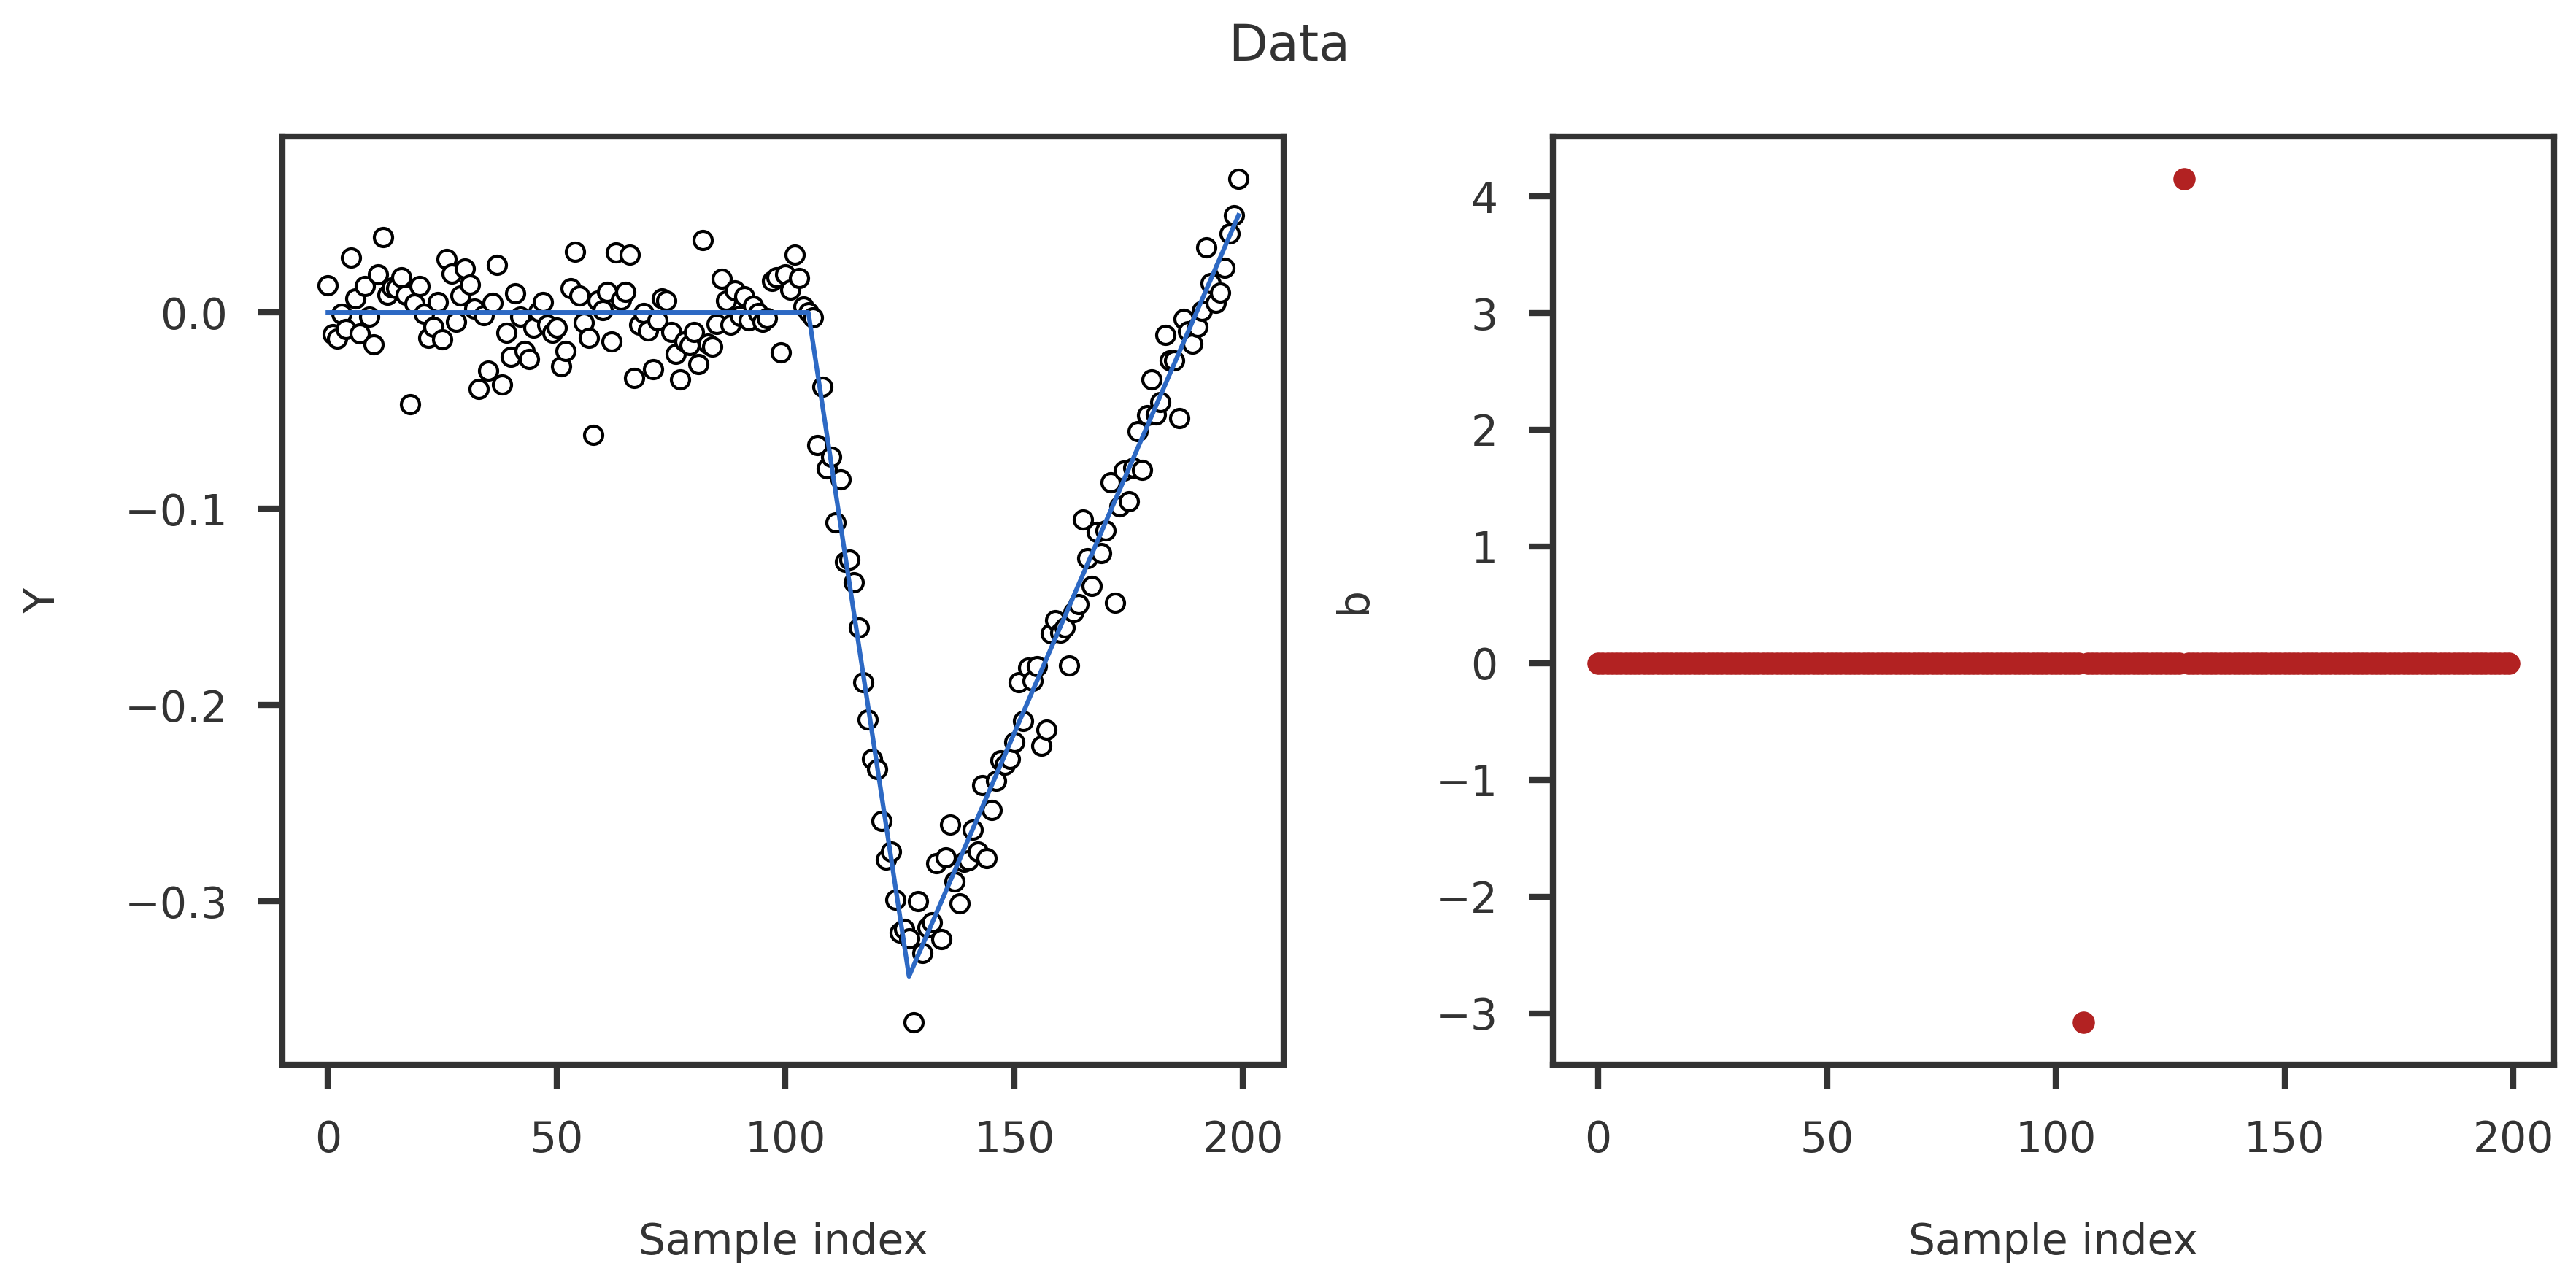

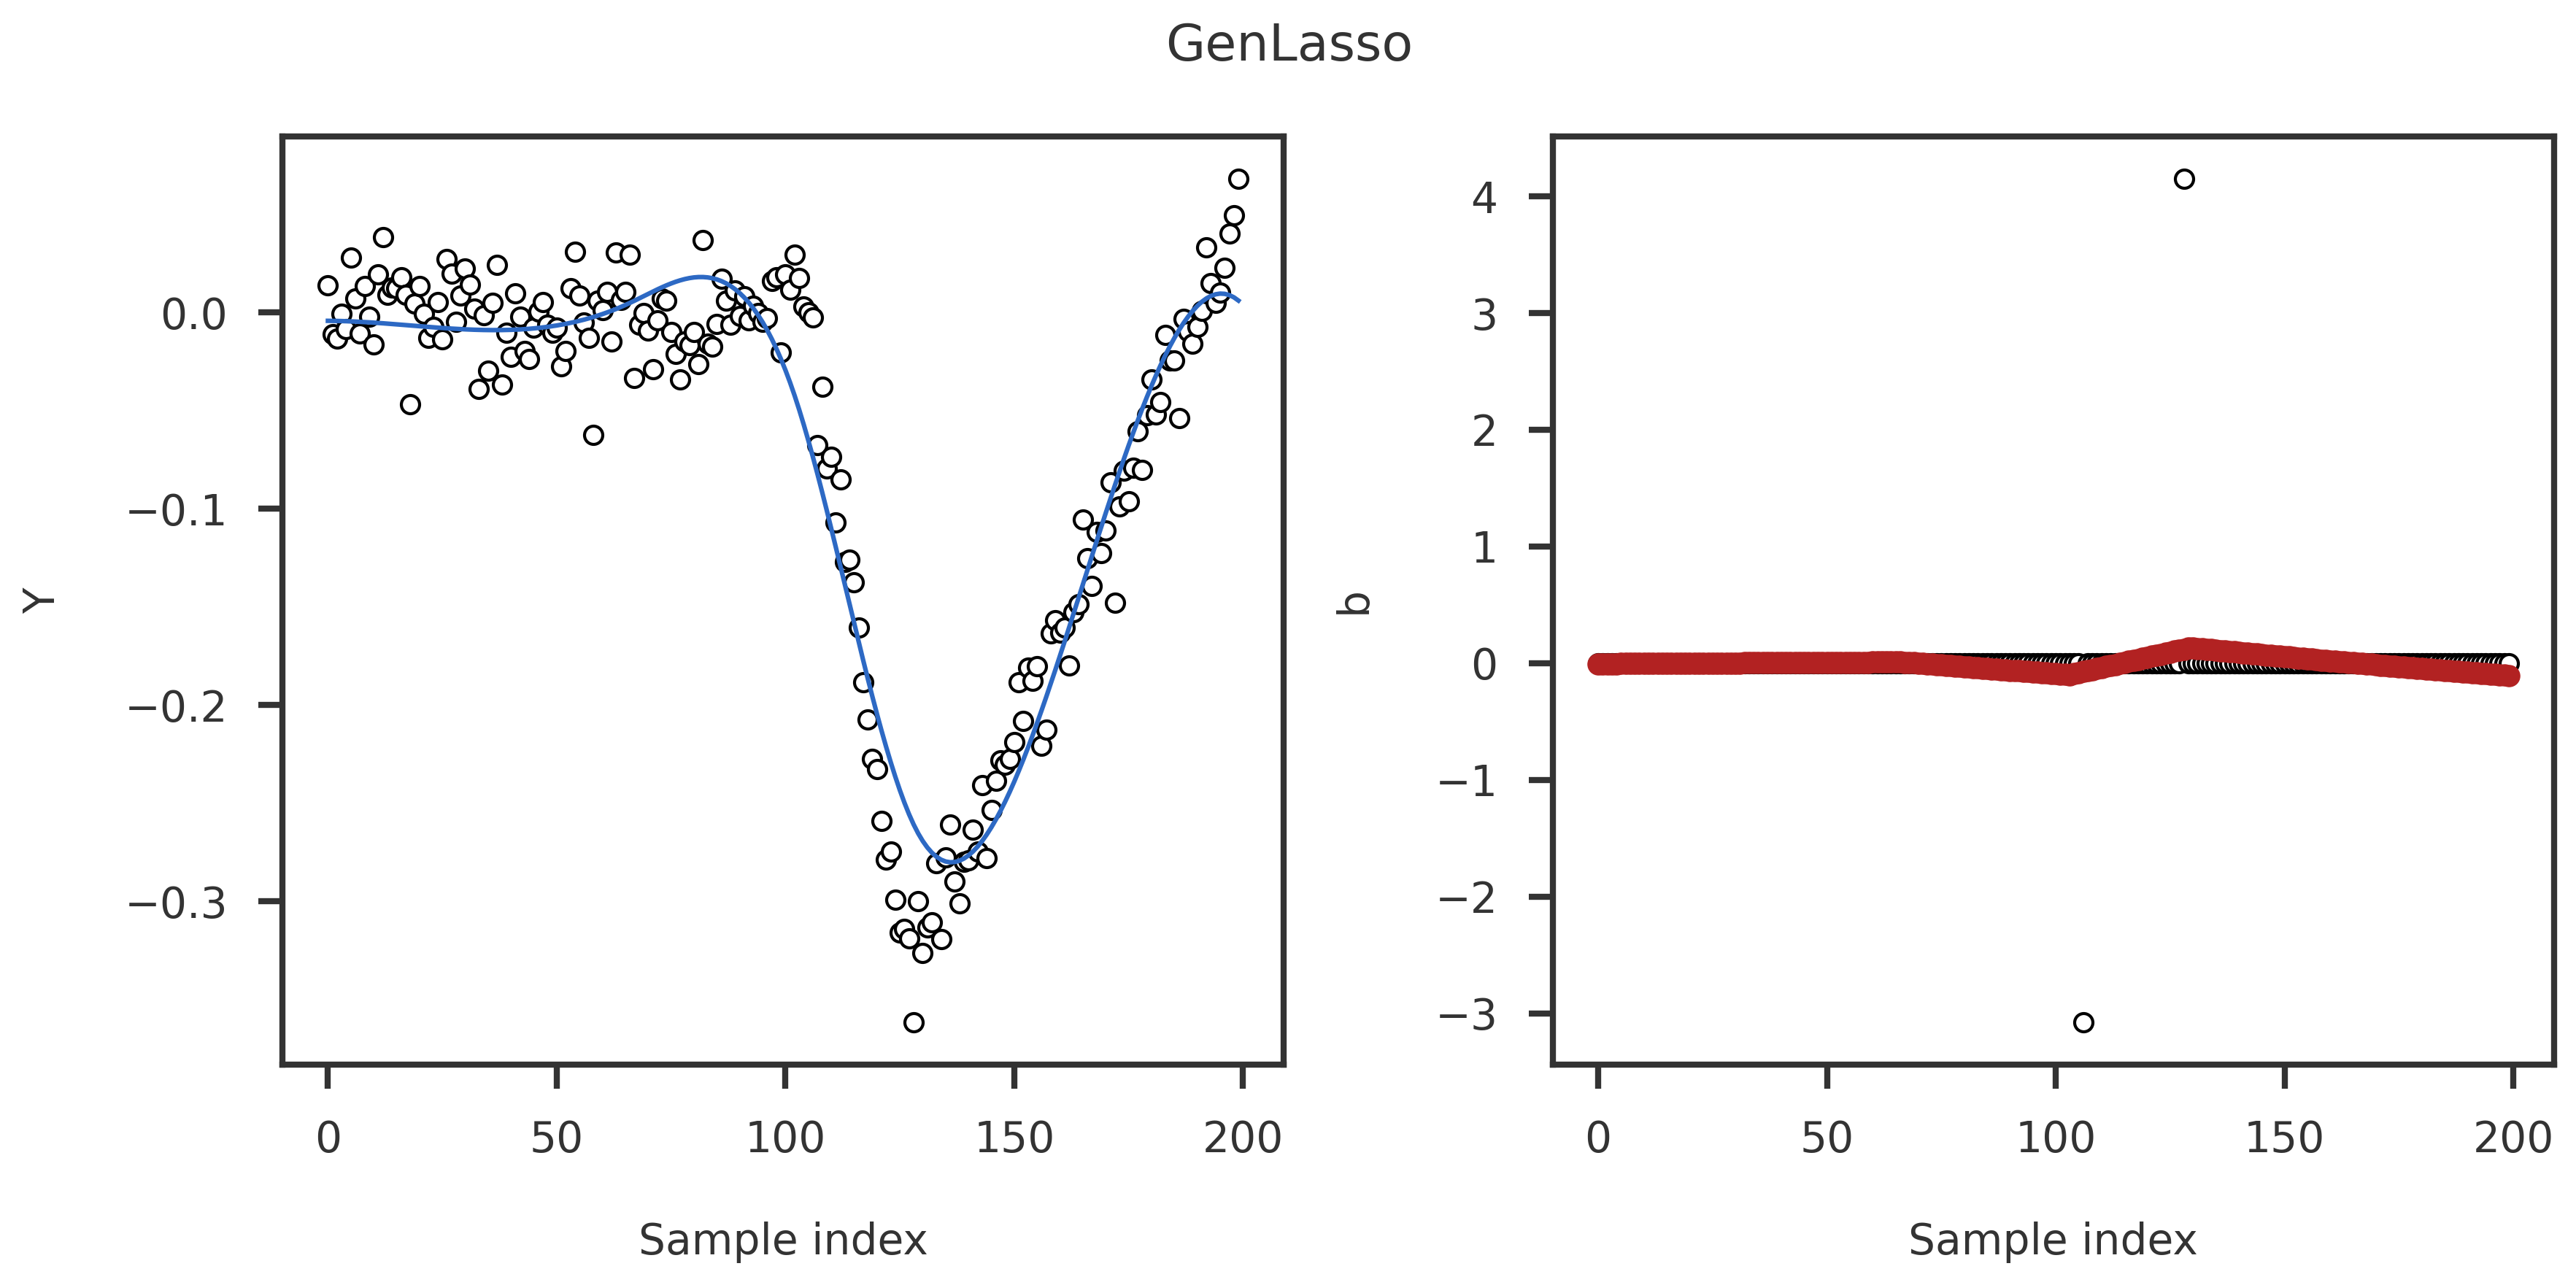

In [6]:
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     btrue, intercept = 0, title = 'Data')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     genlasso_b, intercept = genlasso_a0, title = 'GenLasso')

In [7]:
'''
Genlasso results
'''
genlasso_a0, genlasso_b, _ = R_genlasso.fit(X, y, order = 0)
genlasso_b = genlasso_b.reshape(-1,)
s2init = np.var(y - np.dot(X, genlasso_b) - genlasso_a0)
print ("Genlasso initialization")


'''
Initialization of theta and w for mr.ash.pen
'''
plr_init = PLR(method = 'L-BFGS-B', is_prior_scaled = True, optimize_s = False,
               function_call = 'python',
               debug = False, display_progress = False, calculate_elbo = False, 
               maxiter = 2000, tol = 1e-8)
plr_init.fit(np.eye(p), genlasso_b, sk, binit = genlasso_b, winit = wk, s2init = s2init)
theta_init = plr_init.theta
winit = plr_init.prior
# winit = mix_gauss.emfit(genlasso_b, sk)

'''
Use the initial theta for mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True, function_call = 'python',
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8)
plr_lbfgs.fit(X, y, sk, binit = theta_init, winit = winit, s2init = s2init, is_binit_coef = False)


'''
Use the initial coefficients for mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, binit = genlasso_b, winit = winit, s2init = s2init, is_binit_coef = False,
               maxiter = 200, qb_maxiter = 50, calculate_elbo = True)


'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = genlasso_b, winit = winit, s2init = s2init)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 

Genlasso initialization
mr.ash.pen terminated at iteration 54.
mr.ash.pen terminated at iteration 762.
mr.ash.pen (EM) terminated at iteration 4.
Mr.ASH terminated at iteration 2000.
Mr.ASH terminated at iteration 1695.


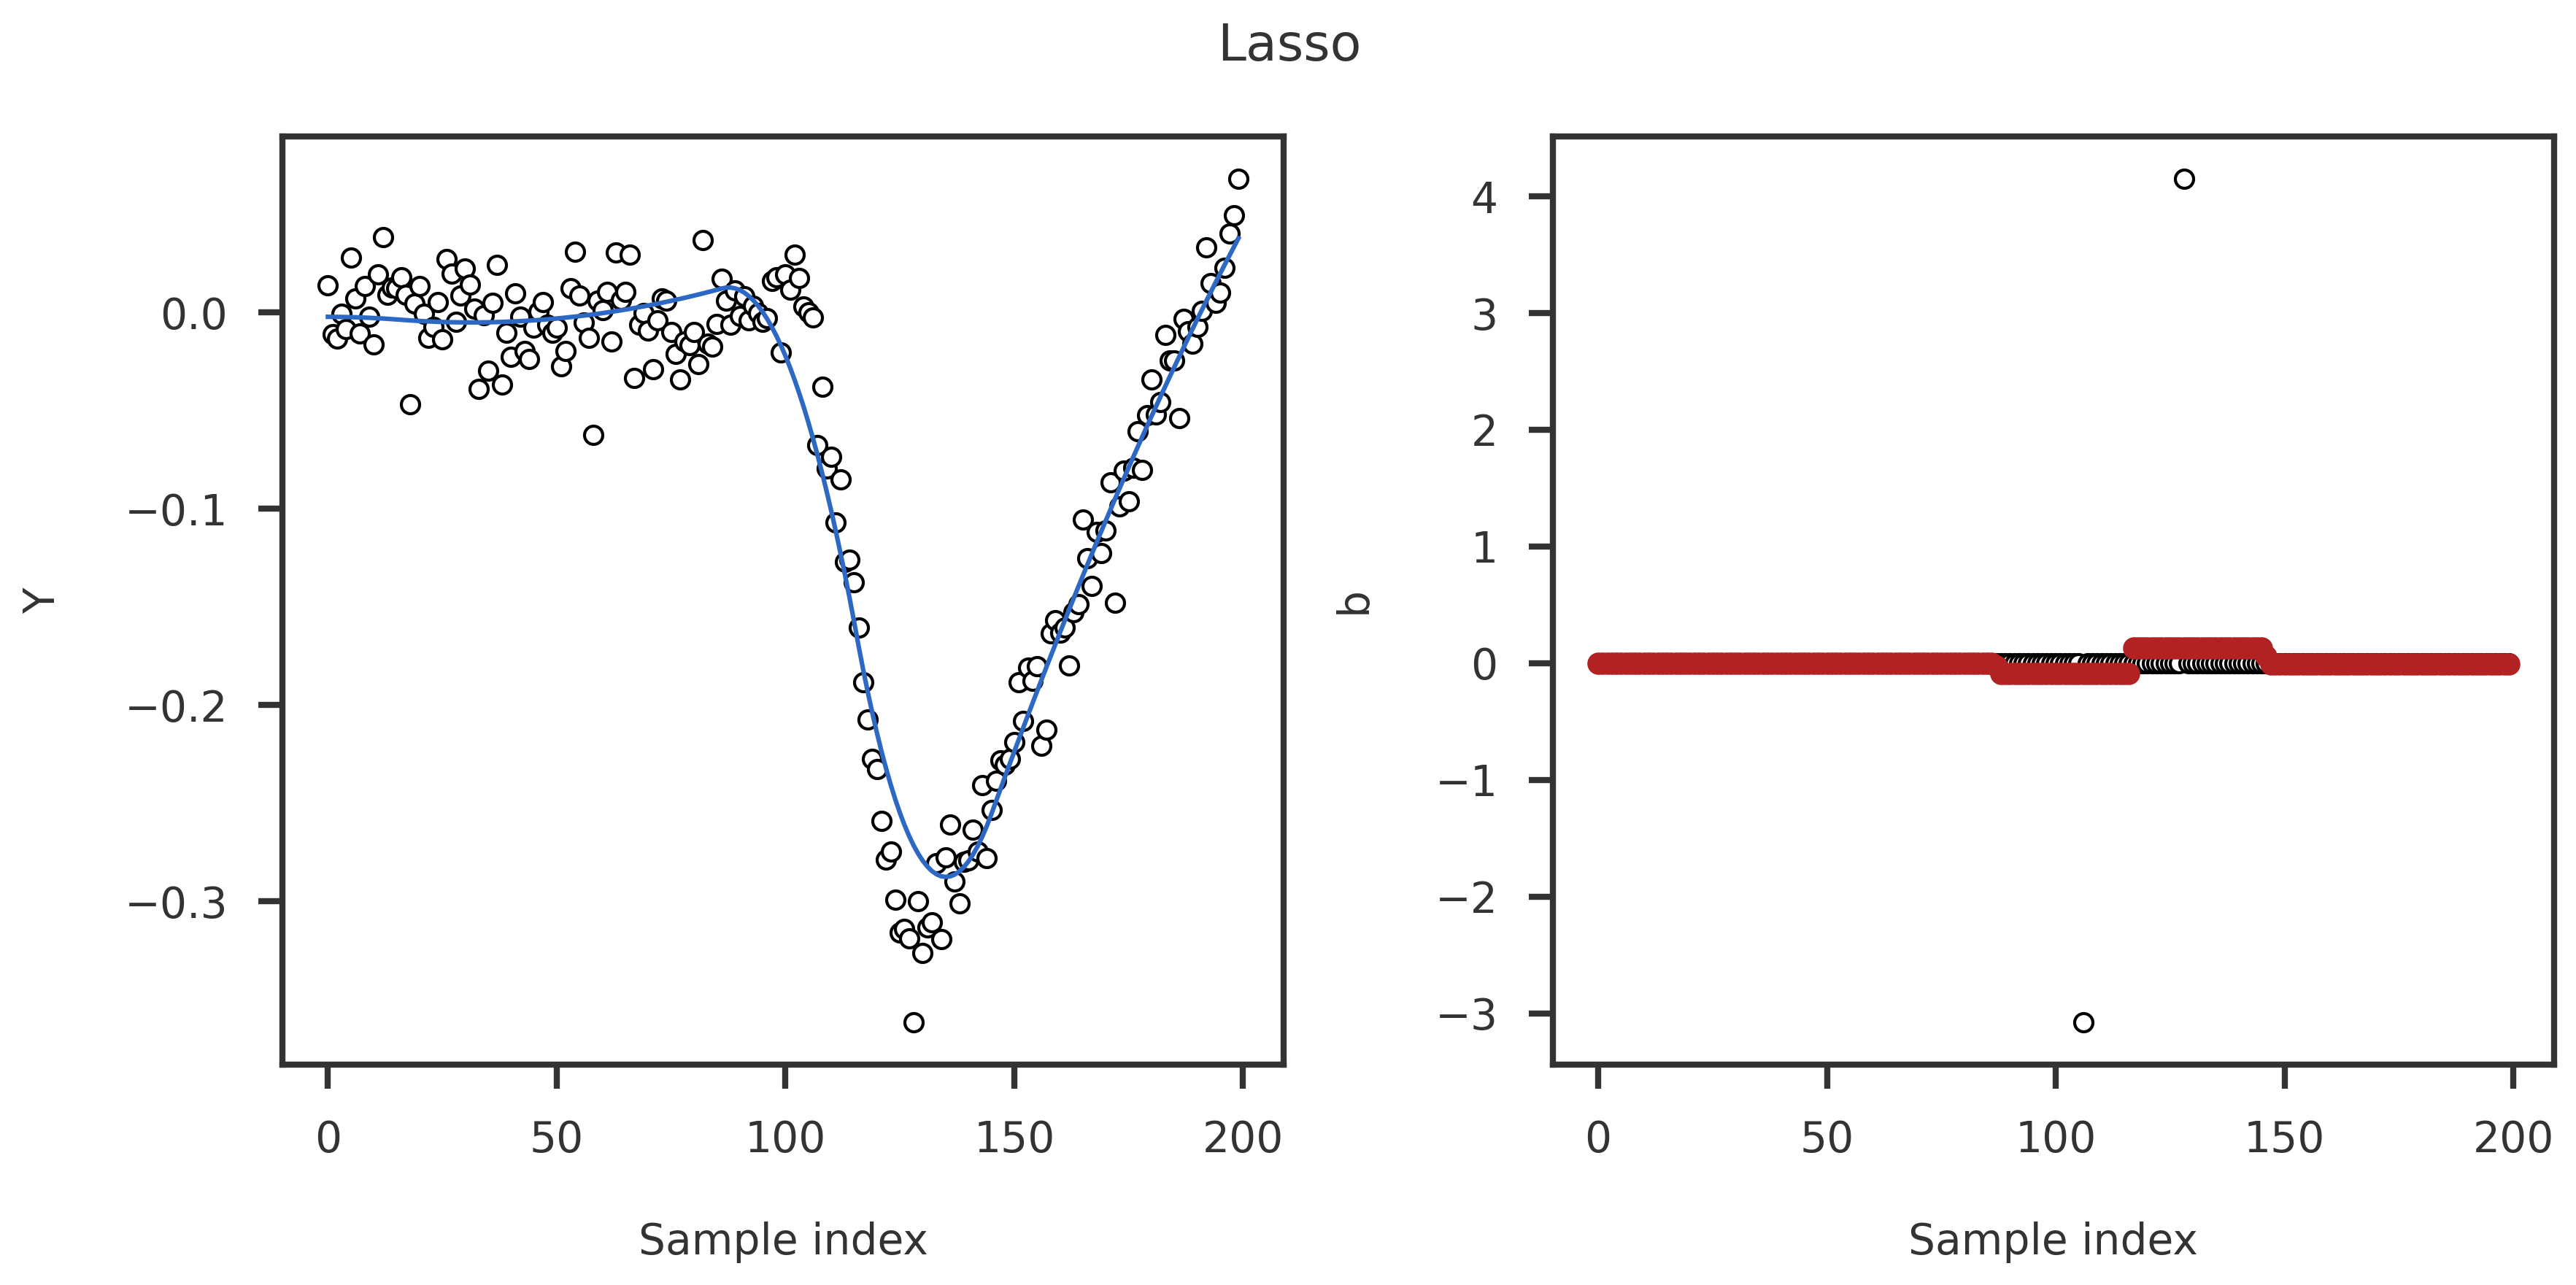

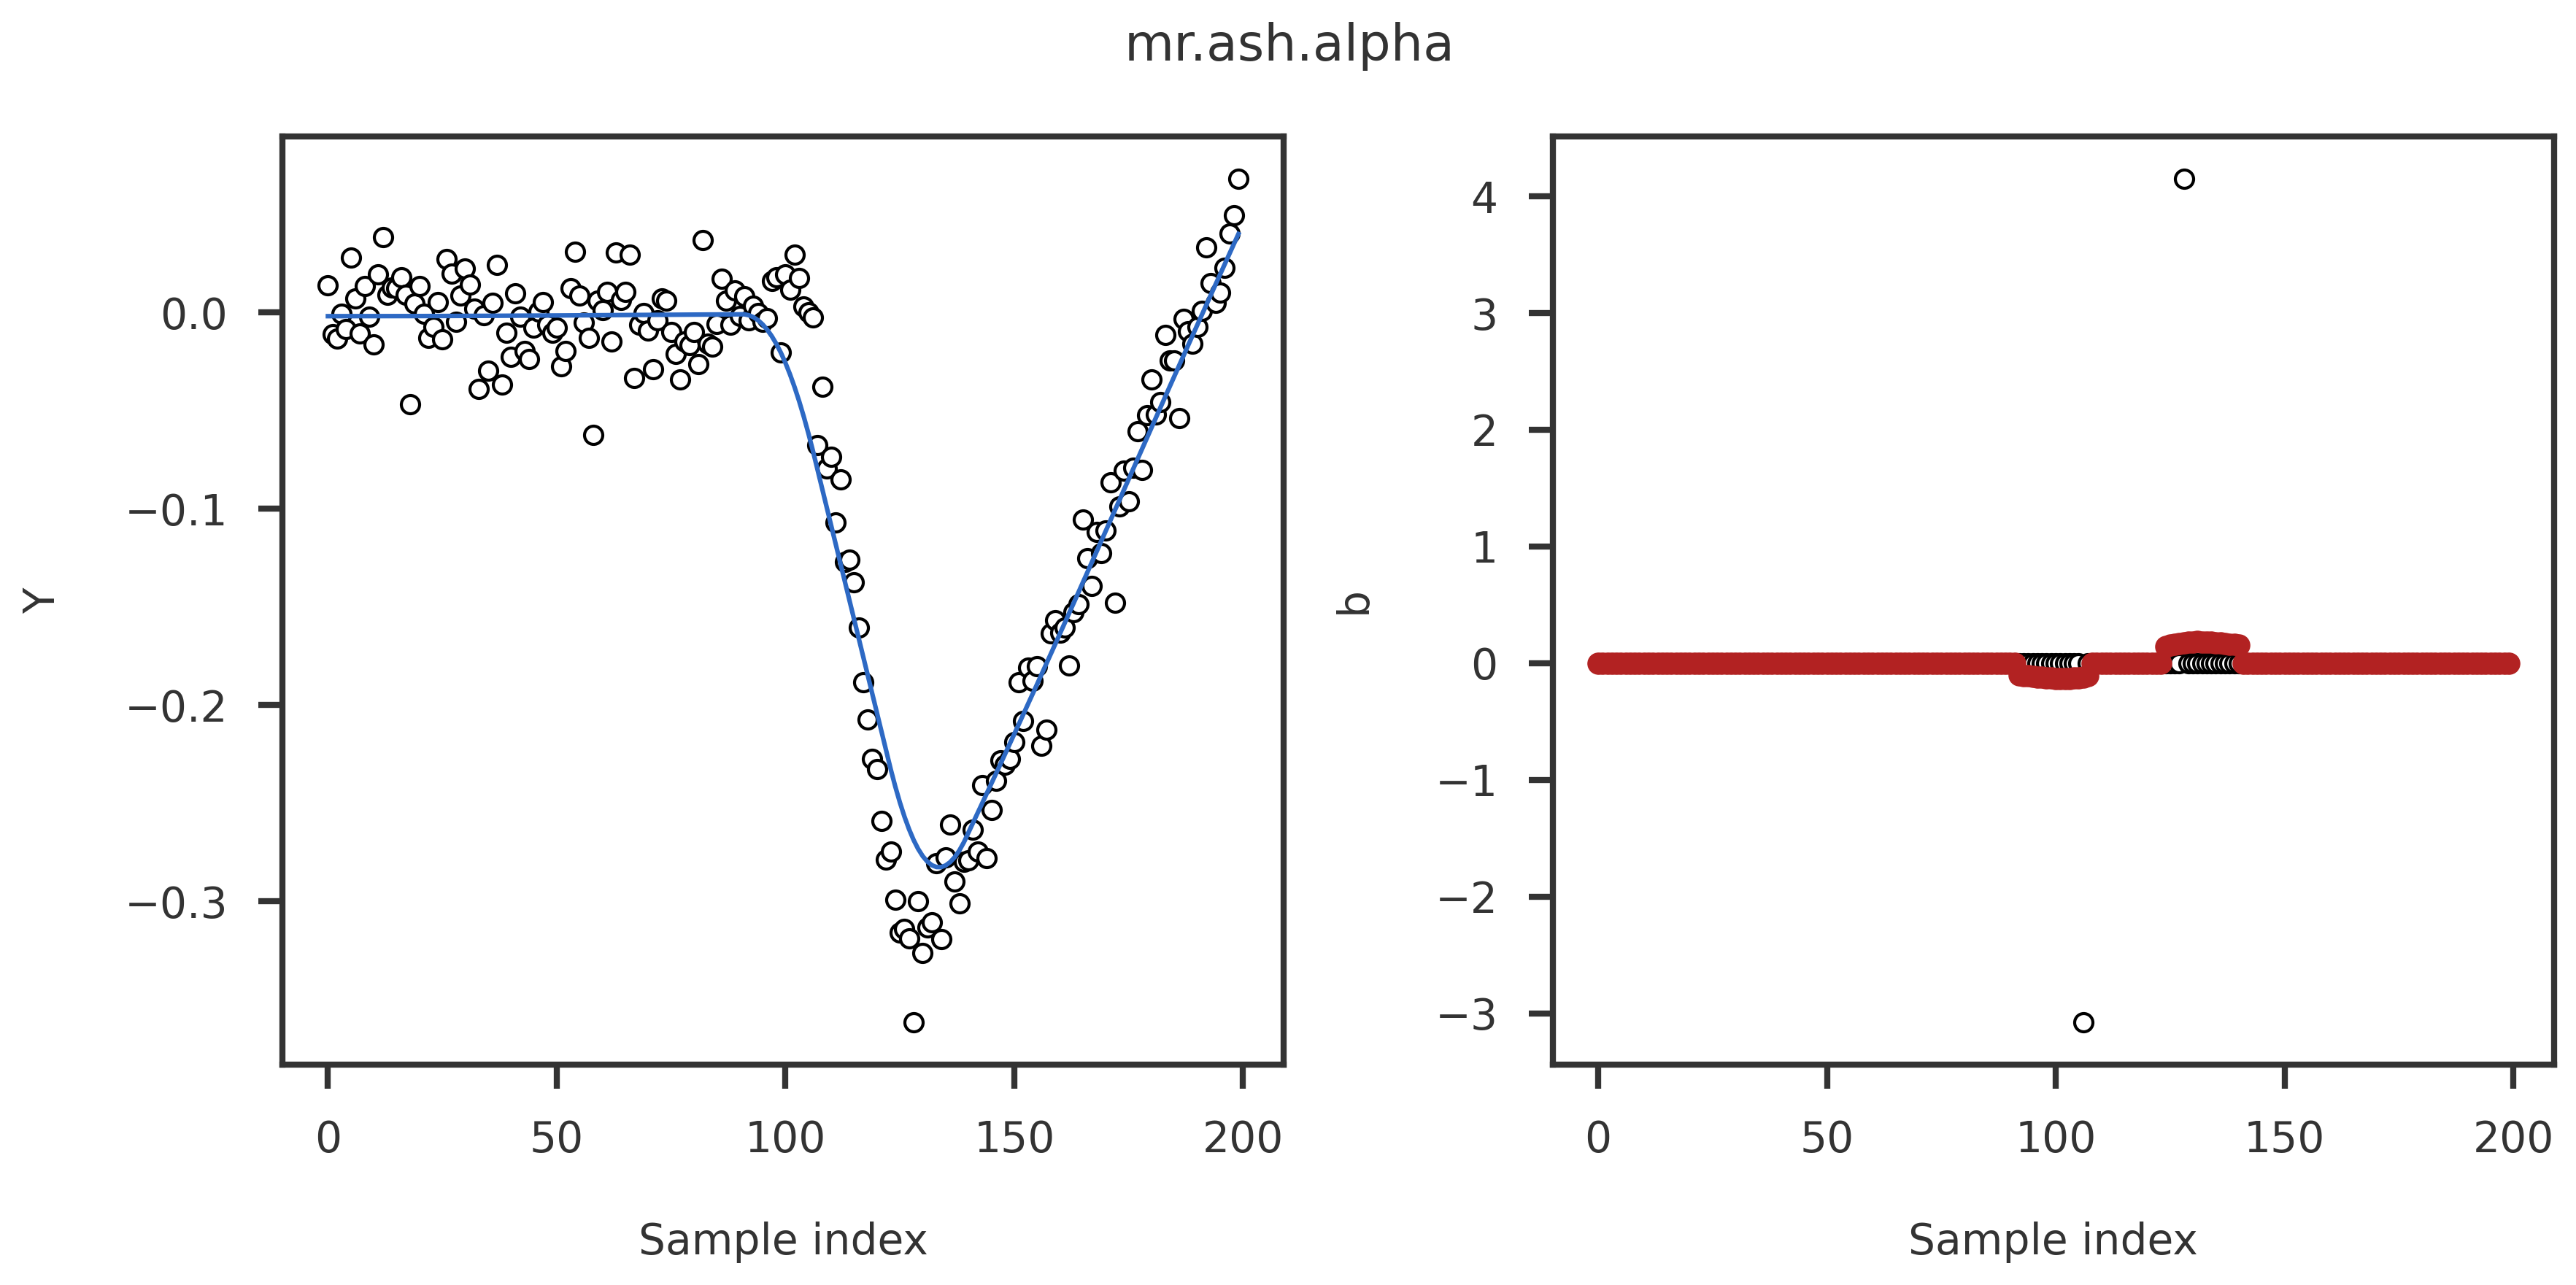

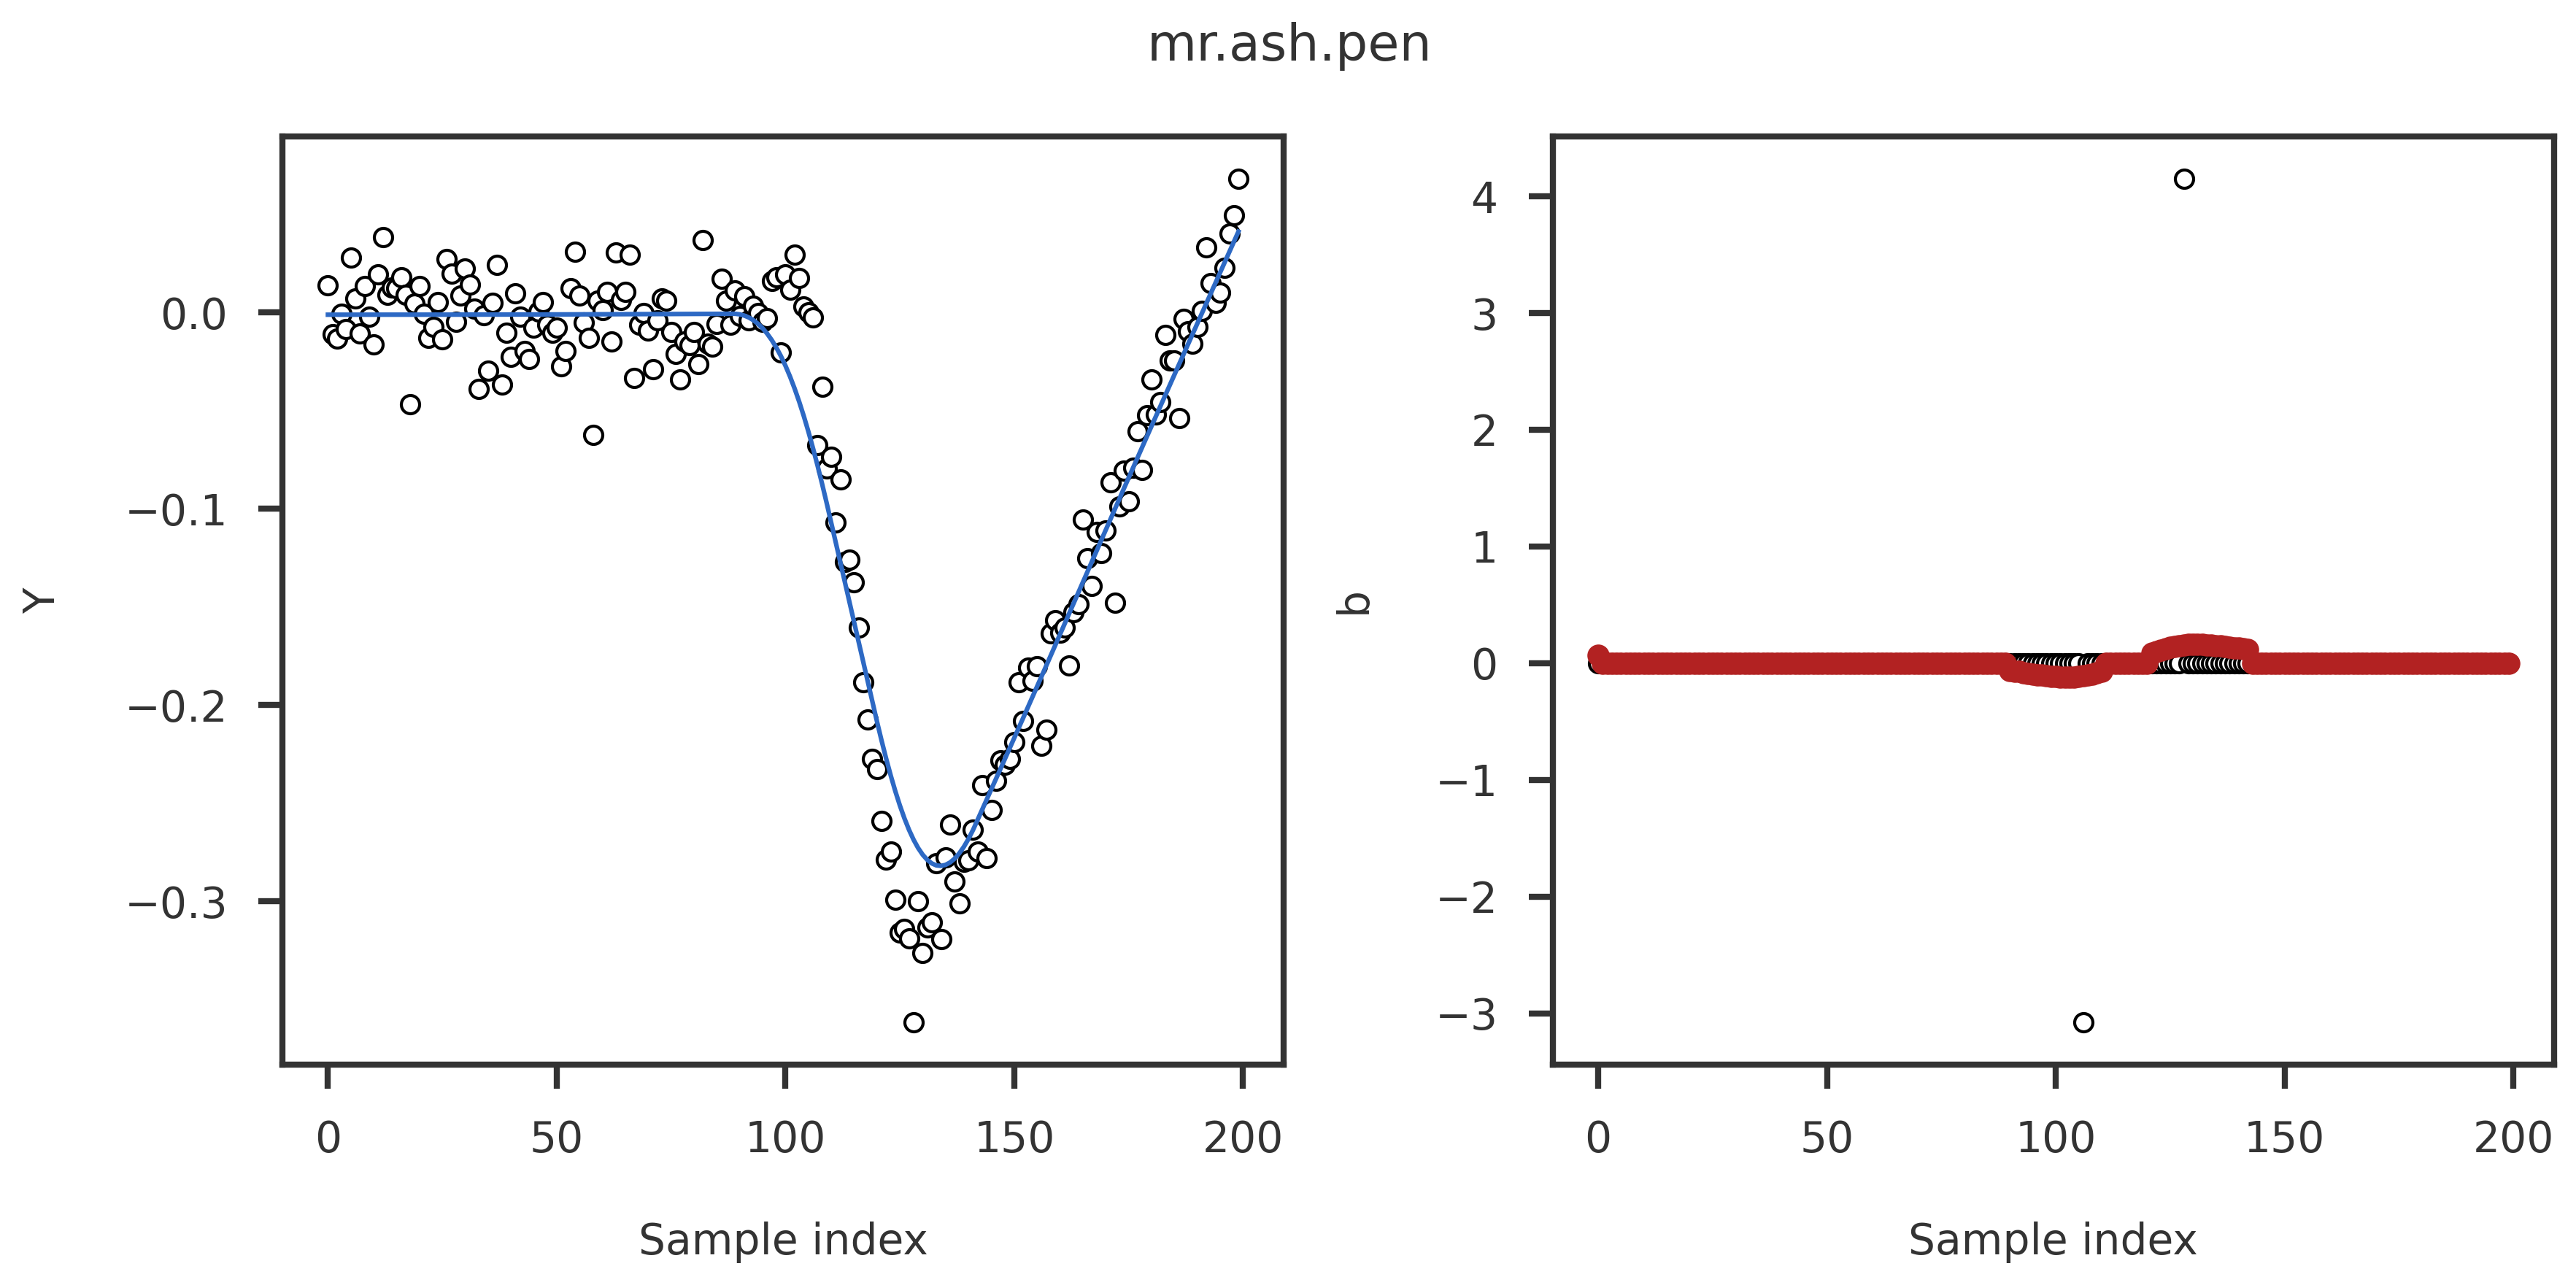

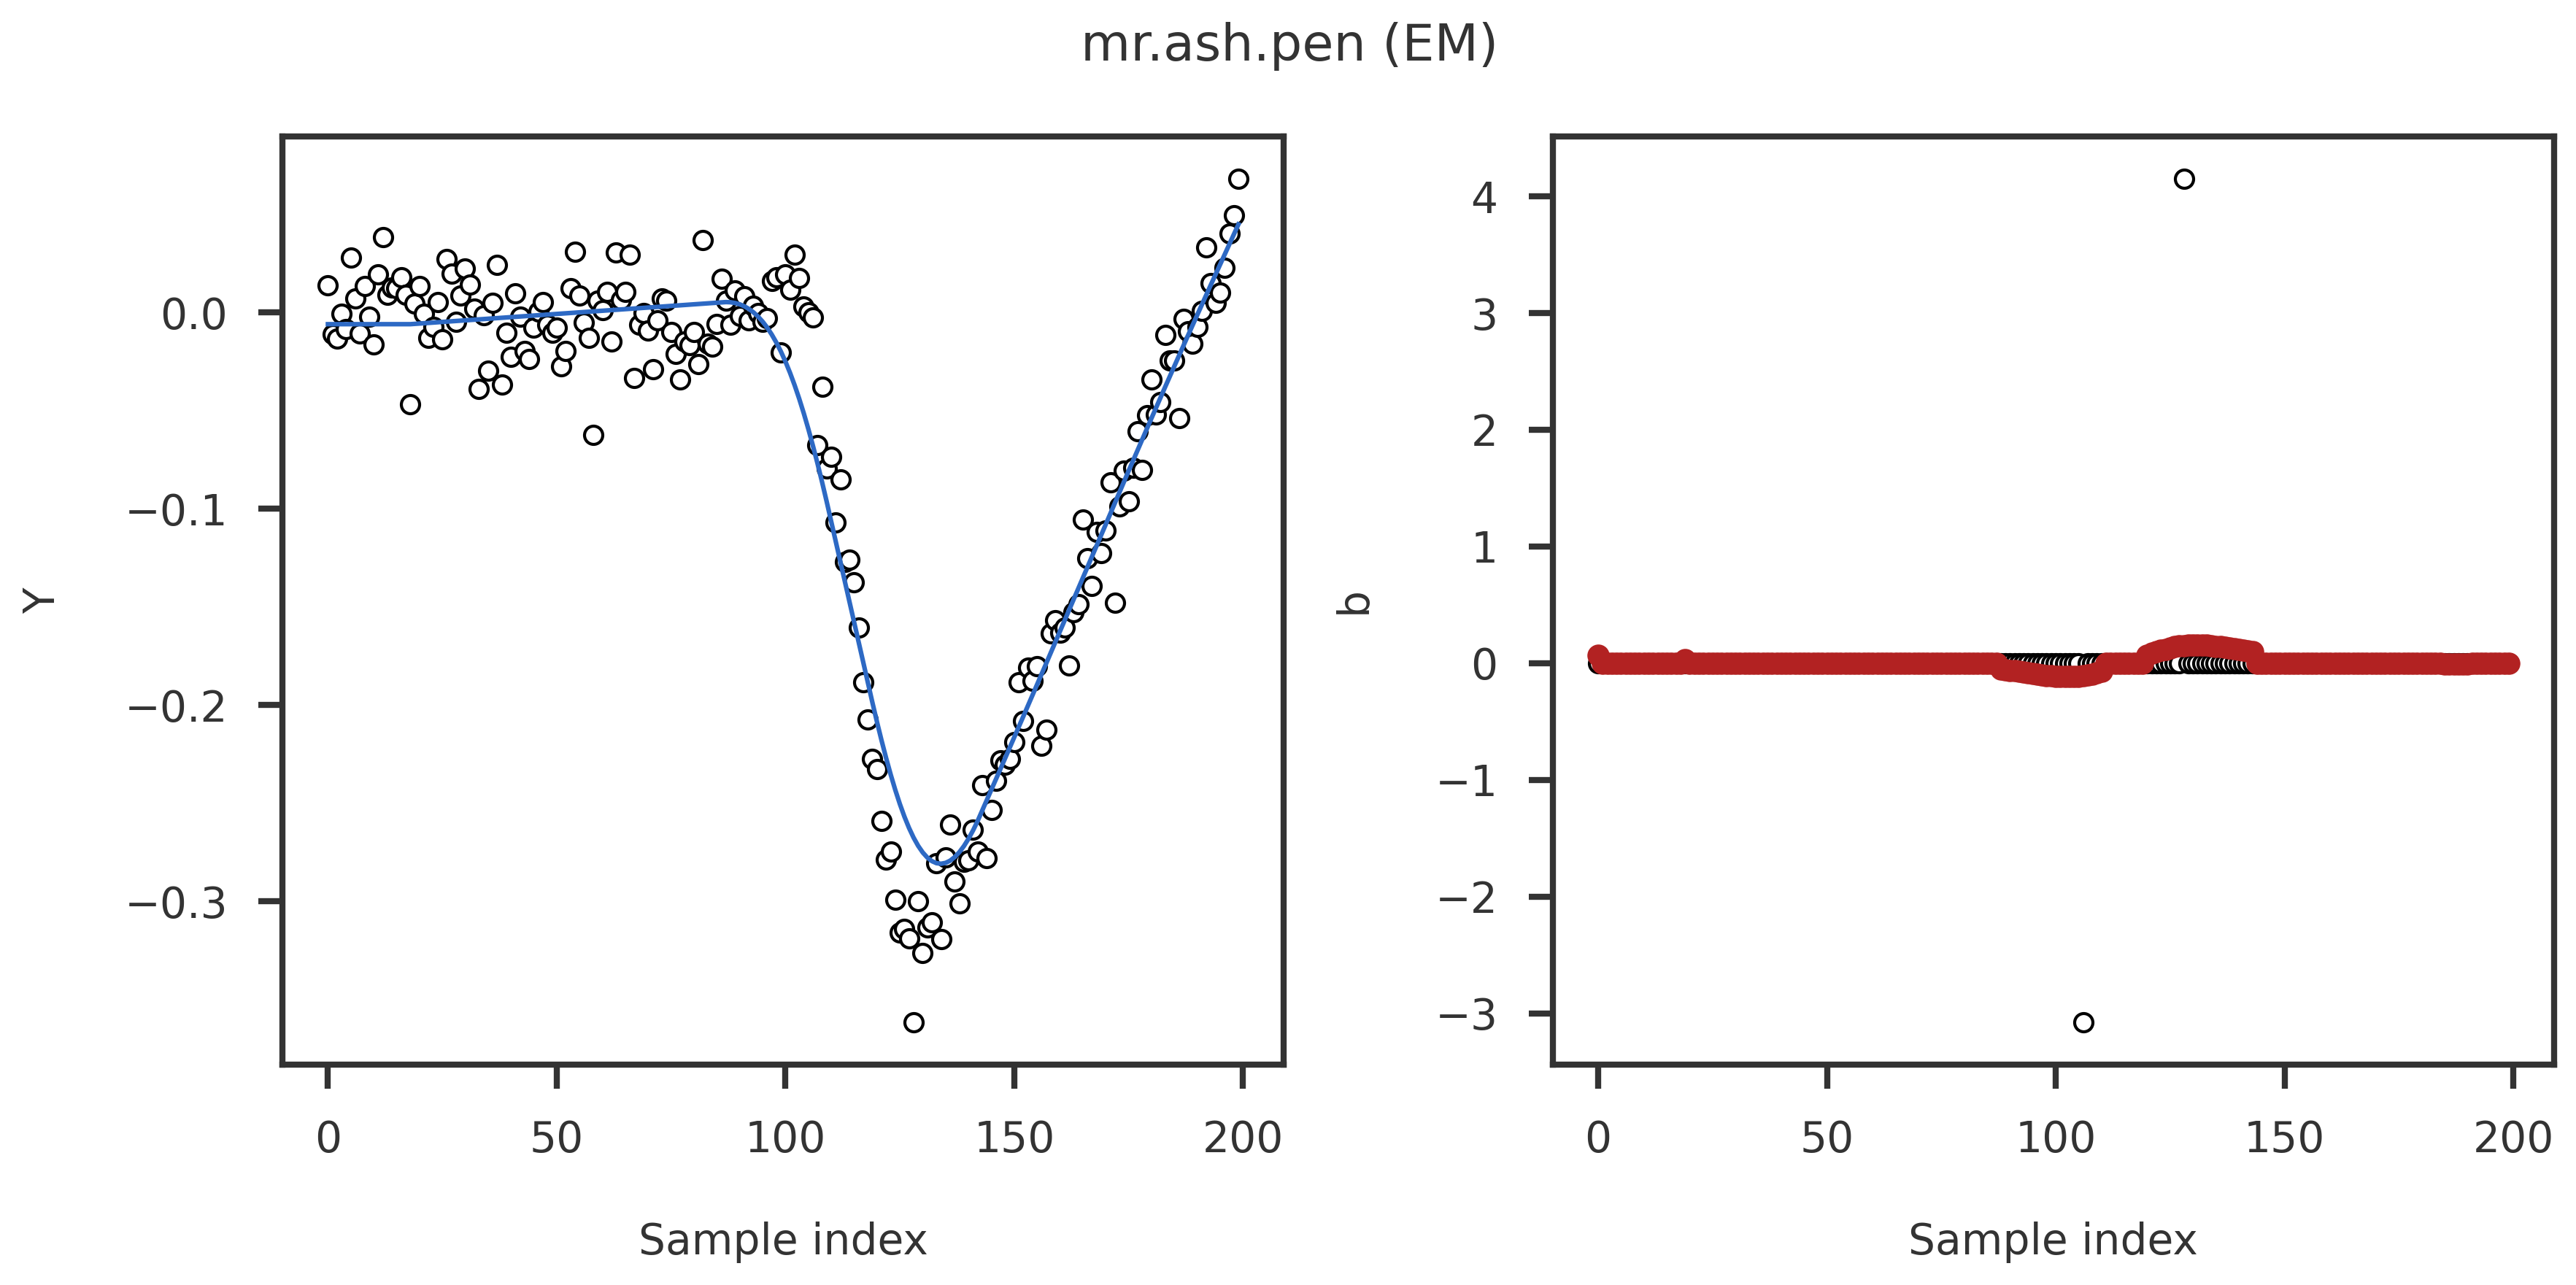

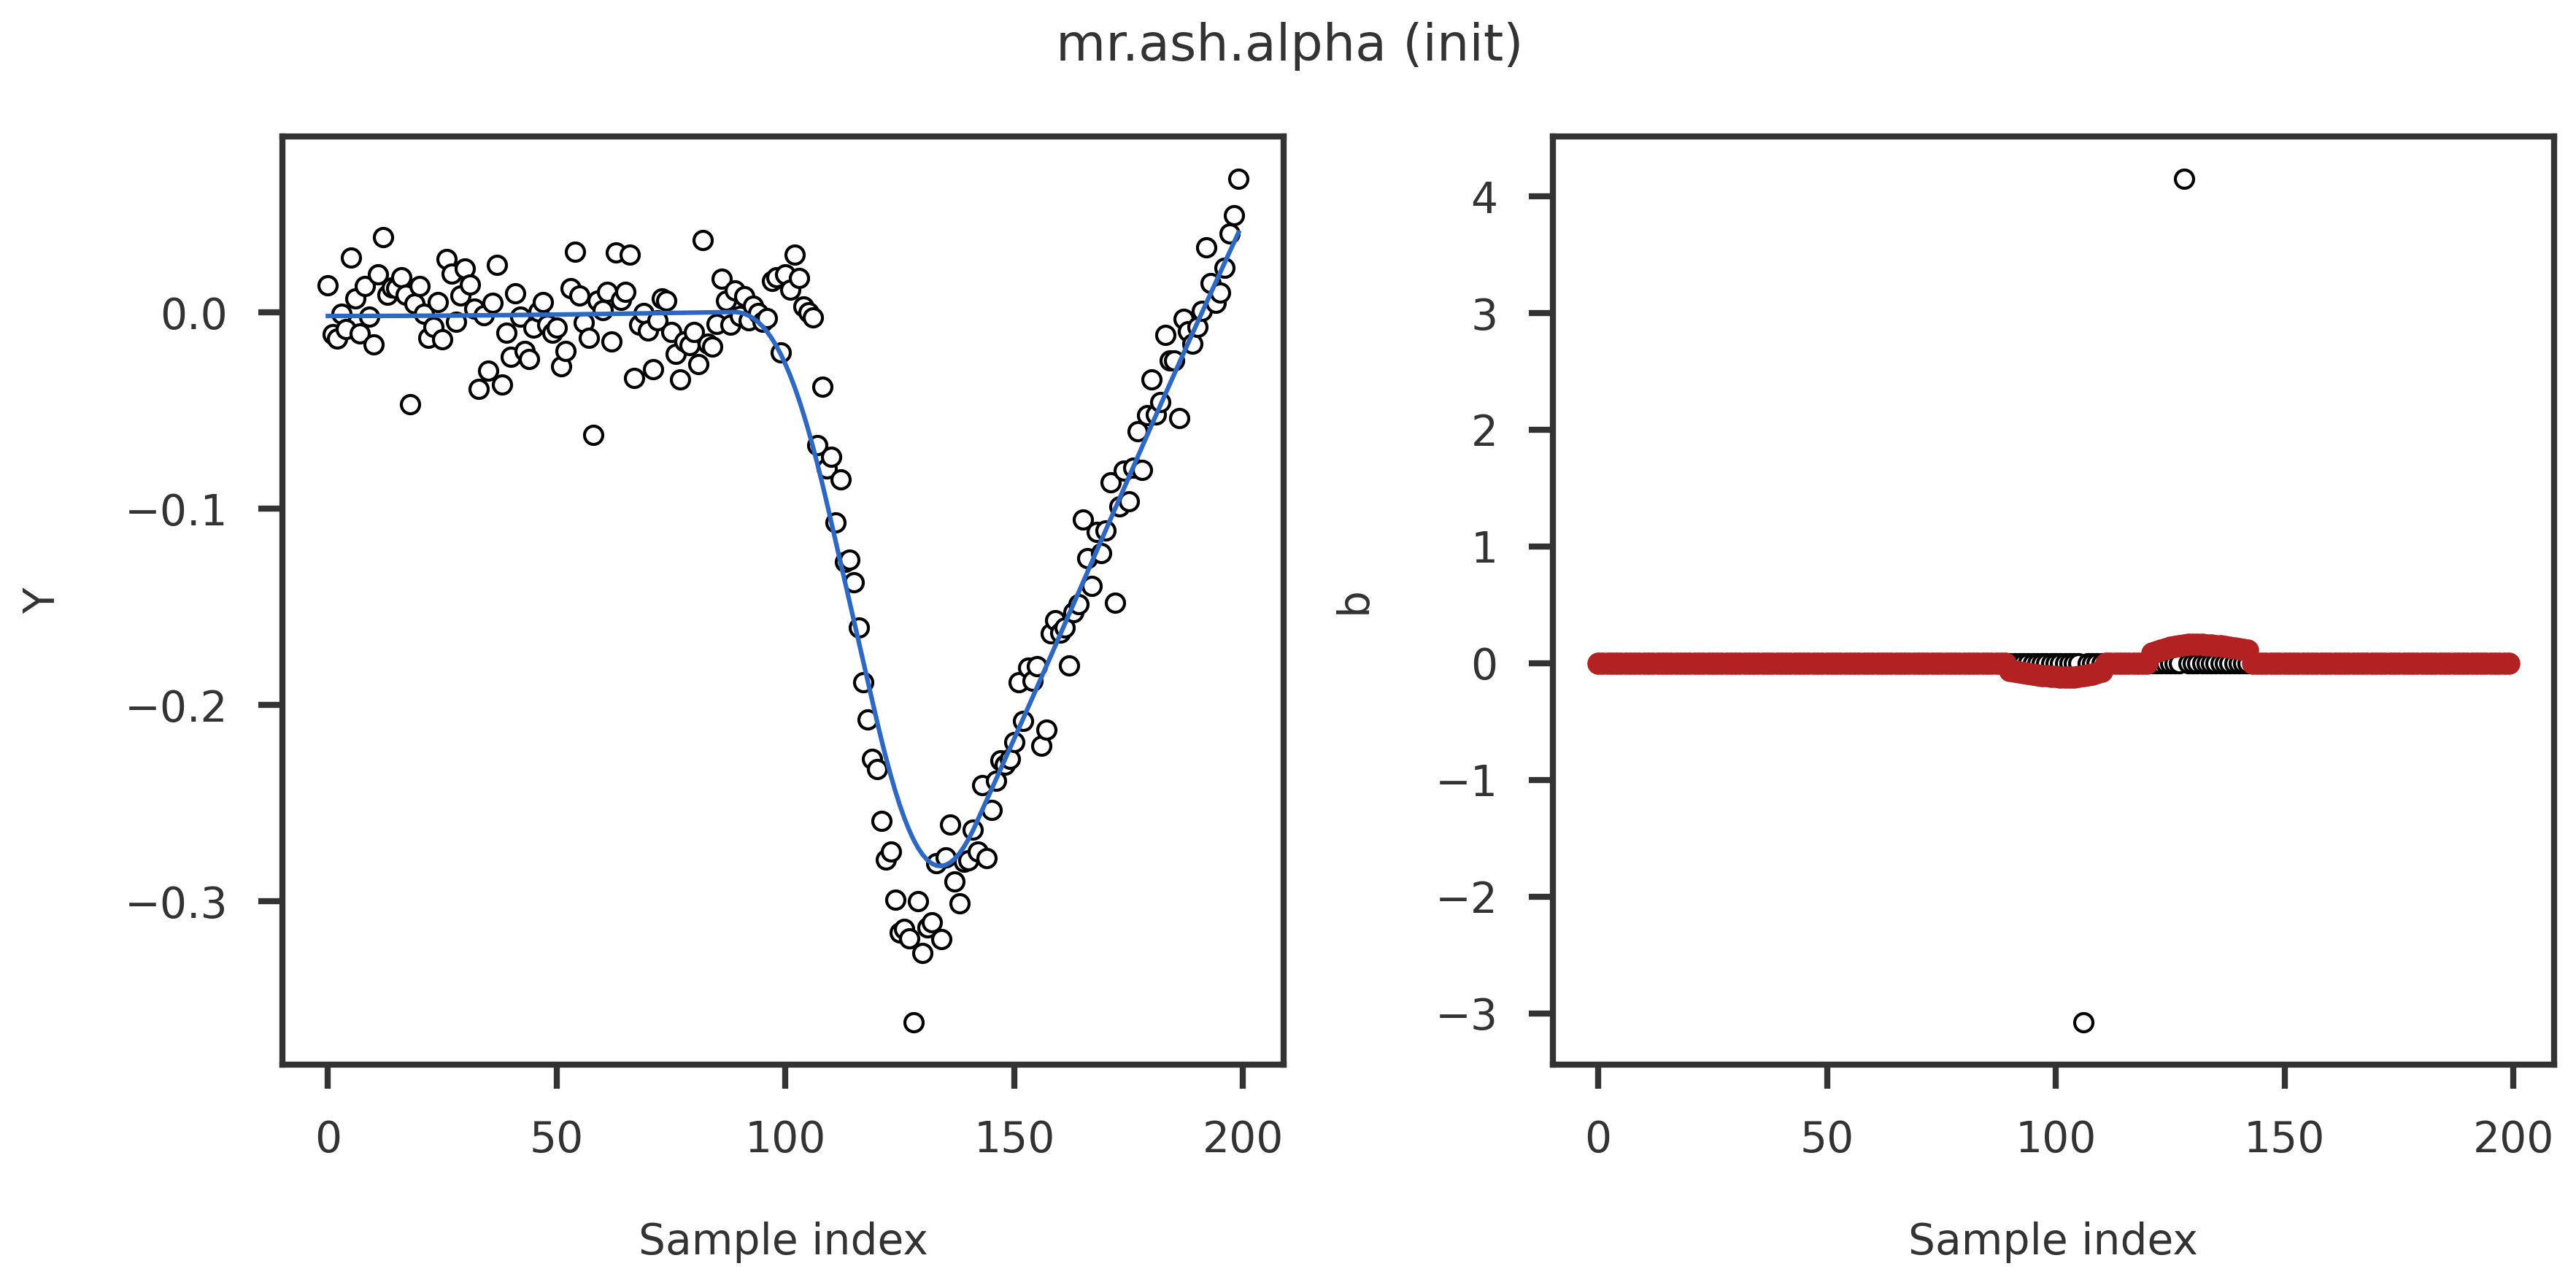

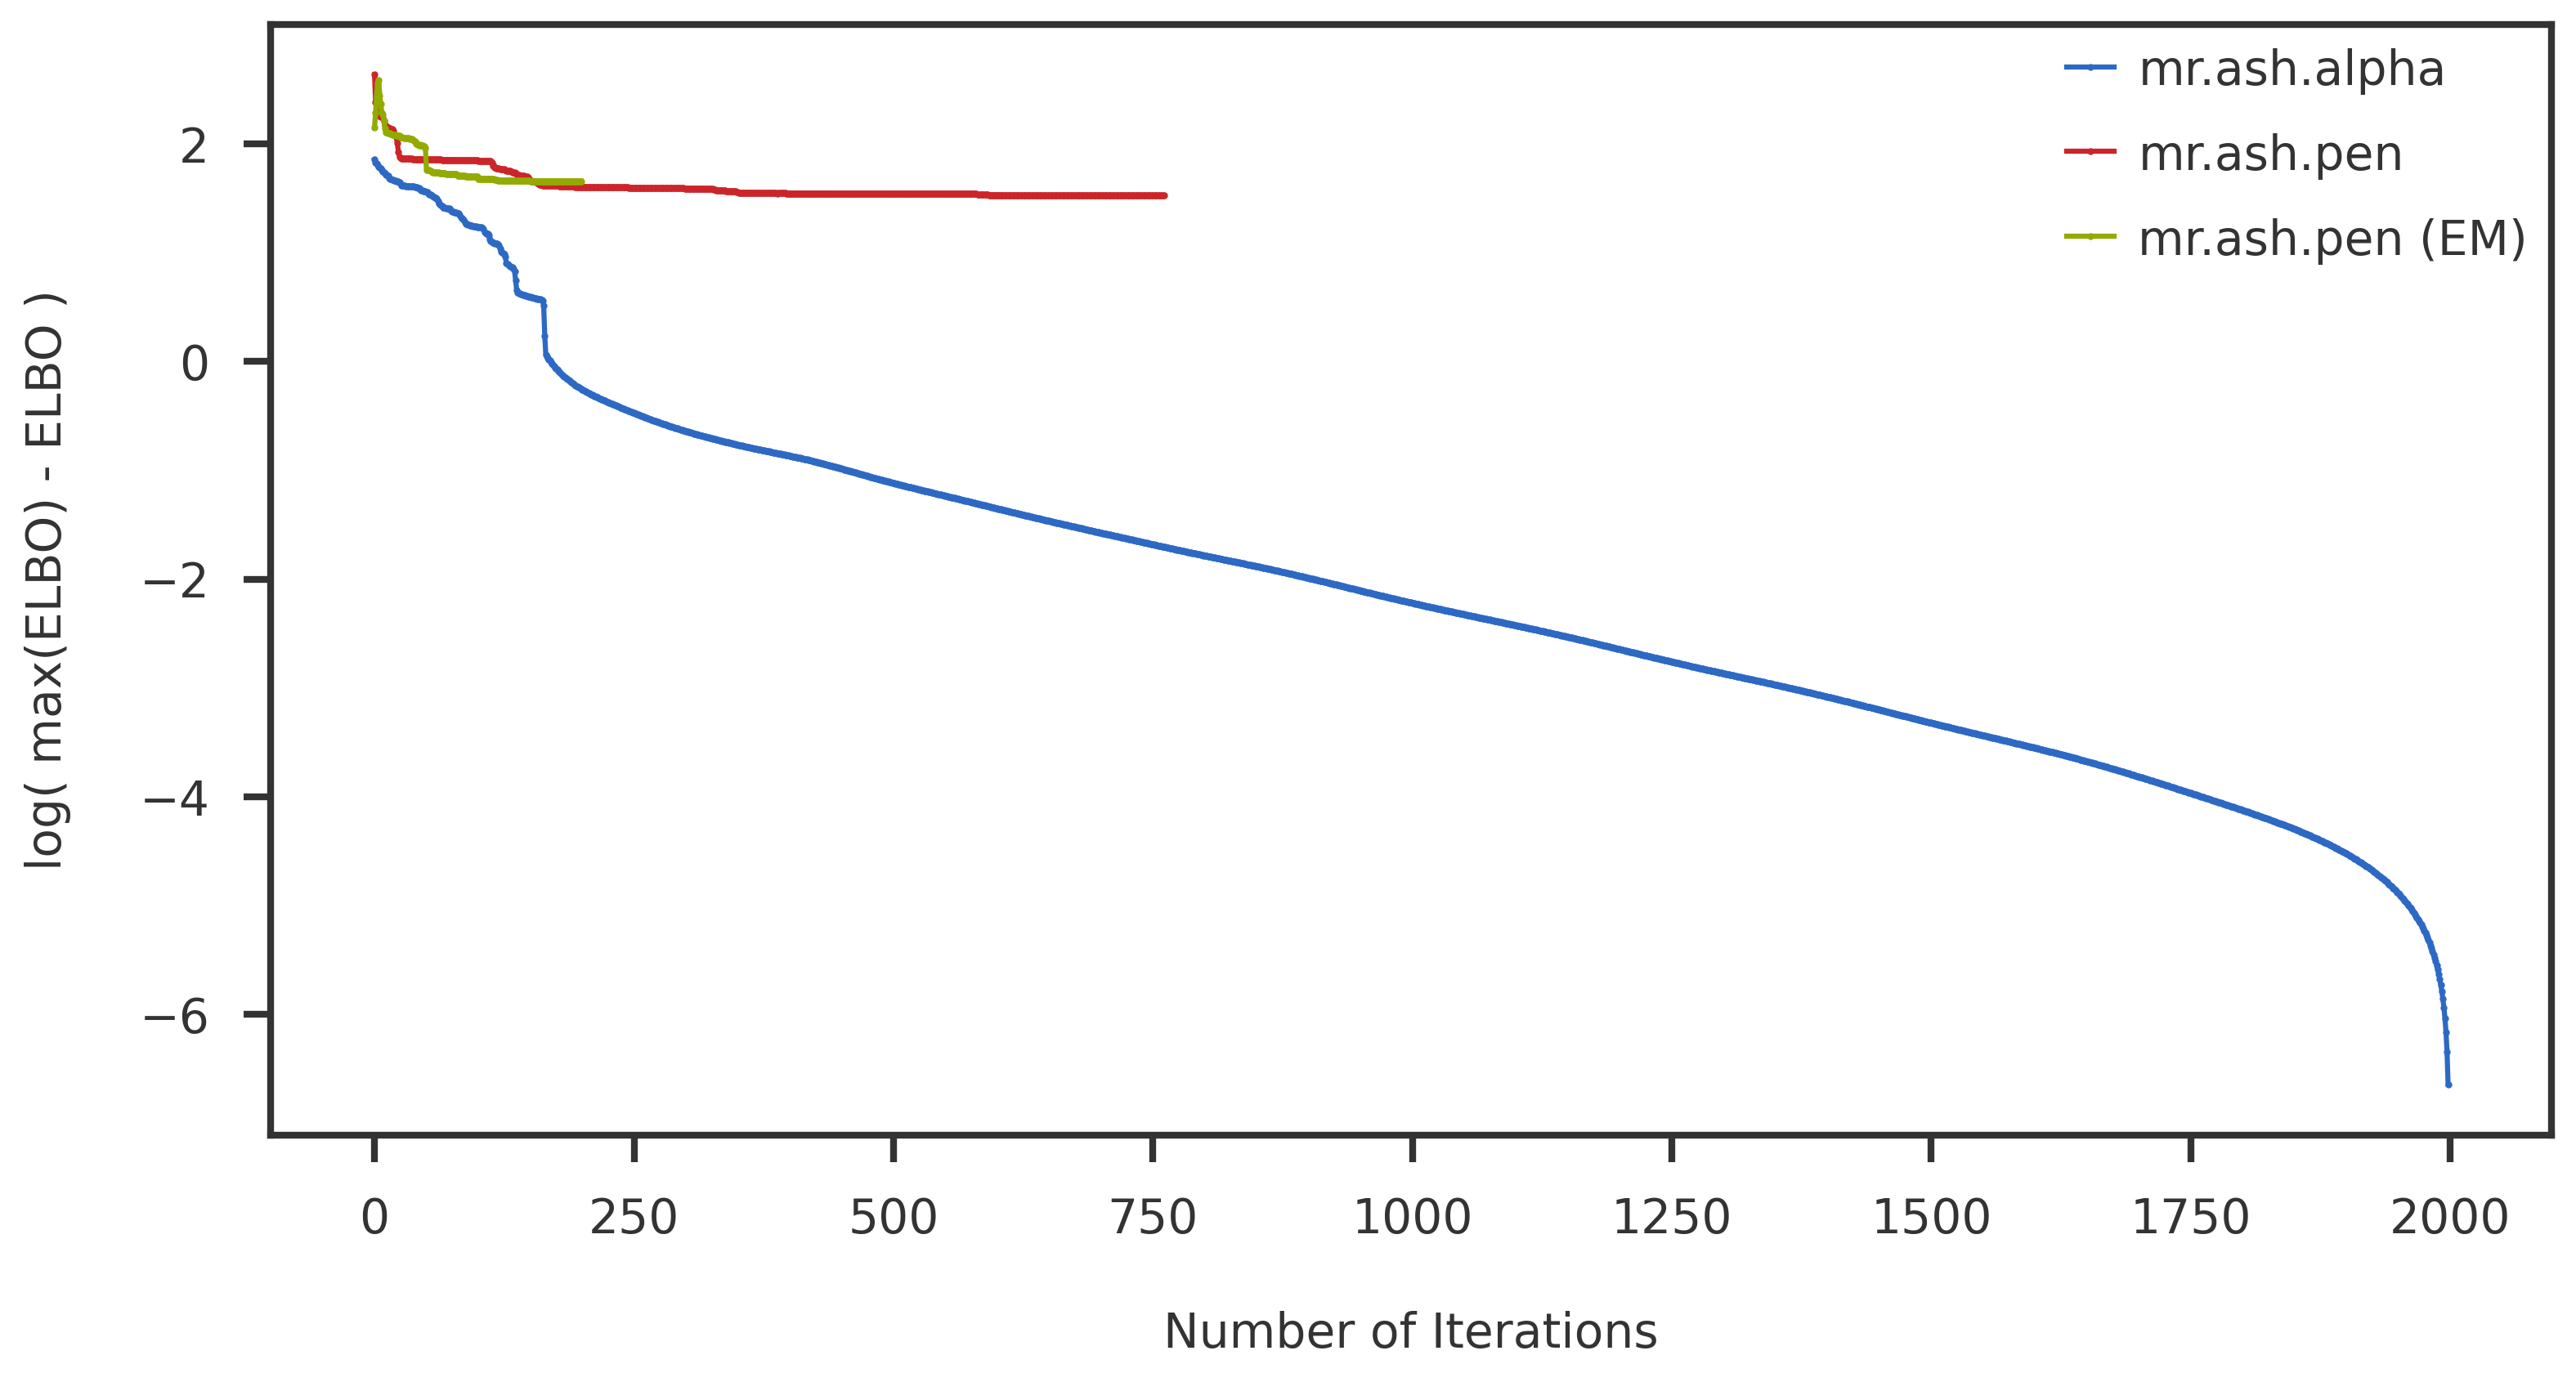

In [8]:
'''
Plot
'''
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     genlasso_b, intercept = genlasso_a0, title = 'Lasso')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
# kinit   = [0, 0, 0]
# objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path]
# methods = ["mr.ash.alpha", "mr.ash.pen"]
# kinit   = [0, 0]
# objs    = [plr_lbfgs.elbo_path, plr_eb.outer_elbo_path]
# methods = ["mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [9]:
objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
# objs     = [mrash_r, plr_lbfgs, mrash_r_init]
# methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.alpha (init)"]
# df       = linreg_summary_df(strue, objs, methods)
df

,sigma2,ELBO,niter
True,0.000326,-,-
mr.ash.alpha,0.001167,-264.403439,2000
mr.ash.pen,0.001088,-230.833511,762
mr.ash.pen (EM),0.001065,-218.989961,200
mr.ash.alpha (init),0.001082,-246.079495,1695


In [93]:
s2init

0.6493666581724082